<a href="https://colab.research.google.com/github/siruku6/MethematicsTrial/blob/master/easily_understandable_pattern_recognition/chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


# 第3章 ベイズ決定則

## p.42

In [6]:
# -------------- 前提条件 --------------
# それぞれのコインの含有率
pi_s = np.array([0.1, 0.4, 0.5])

# それぞれのコインが表になる確率
front_probs = np.array([0.8, 0.6, 0.3])

# それぞれのコインが裏になる確率
back_probs = 1 - front_probs

## 2章で作った関数

In [7]:
# -------------- Bayesian update --------------
def bayesian_update(front_or_back_probs, prior_probs) -> np.ndarray:
    """
    ベイズ更新を1回だけ実行する関数
    """
    posterior_probs = front_or_back_probs * prior_probs / sum(front_or_back_probs * prior_probs)
    return posterior_probs


def continuous_bayesian_update(
    prior_probs: np.ndarray, series_coin_toss: list
) -> np.ndarray:

    # NOTE: 一切の試行をする前なら、試行から得られる情報が何もないため、
    #     事前確率がそのまま事後確率になる
    posterior_probs = prior_probs

    for cointoss_result in series_coin_toss:
        if cointoss_result == "front":
            probs = front_probs
        elif cointoss_result == "back":
            probs = back_probs

        posterior_probs = bayesian_update(probs, prior_probs)
        prior_probs = posterior_probs

    return posterior_probs

## p.39 ~ 42 3-2 事後確率最大化

In [8]:
available_front_counts = np.arange(11)
prior_probs = pi_s

posterior_probs_dict = {}

for front_count in available_front_counts:
    back_count = 10 - front_count
    series_coin_toss = ["front"] * front_count + ["back"] * back_count

    posterior_probs = continuous_bayesian_update(prior_probs, series_coin_toss)
    posterior_probs_dict[front_count] = posterior_probs

posterior_probs_dict

{0: array([7.22872052e-07, 2.96088393e-03, 9.97038393e-01]),
 1: array([6.69719146e-06, 1.02868861e-02, 9.89706417e-01]),
 2: array([6.09365998e-05, 3.50994815e-02, 9.64839582e-01]),
 3: array([5.22617226e-04, 1.12885321e-01, 8.86592062e-01]),
 4: array([0.0037913 , 0.30709491, 0.68911379]),
 5: array([0.01966587, 0.59735088, 0.38298325]),
 6: array([0.06907423, 0.78679862, 0.14412716]),
 7: array([0.18198217, 0.777334  , 0.04068383]),
 8: array([0.3808422 , 0.61003556, 0.00912224]),
 9: array([0.62373543, 0.37466383, 0.00160074]),
 10: array([8.15974145e-01, 1.83801488e-01, 2.24367051e-04])}

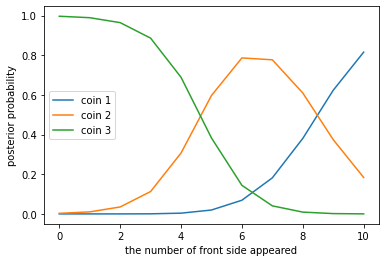

In [13]:
result_10 = pd.DataFrame.from_dict(posterior_probs_dict, orient="index")
plt.plot(result_10[0], label="coin 1")
plt.plot(result_10[1], label="coin 2")
plt.plot(result_10[2], label="coin 3")
plt.xlabel("the number of front side appeared")
plt.ylabel("posterior probability")
plt.legend()
plt.show()

p.42のグラフとほぼ同じ結果になった

## p.43 ~ 45 事後確率の効果

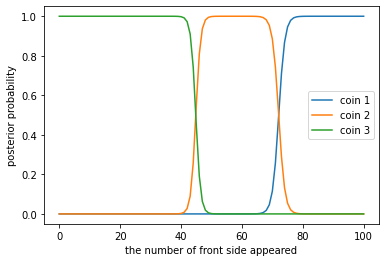

In [14]:
available_front_counts = np.arange(101)
prior_probs = pi_s

posterior_probs_dict = {}

for front_count in available_front_counts:
    back_count = 100 - front_count
    series_coin_toss = ["front"] * front_count + ["back"] * back_count

    posterior_probs = continuous_bayesian_update(prior_probs, series_coin_toss)
    posterior_probs_dict[front_count] = posterior_probs

result_100 = pd.DataFrame.from_dict(posterior_probs_dict, orient="index")

plt.plot(result_100[0], label="coin 1")
plt.plot(result_100[1], label="coin 2")
plt.plot(result_100[2], label="coin 3")
plt.xlabel("the number of front side appeared")
plt.ylabel("posterior probability")
plt.legend()
plt.show()

In [ ]:
probability_of_error = 1 - result_10.max(axis=1)

## p.45~ 3-4 ベイズ誤り確率

In [22]:
def number_of_combinations(n: int, r: int) -> int:
    """
    組み合わせの数を計算する
    ------
    n: int ... total_num
    r: int ... subset_num
    """
    return math.factorial(n) / (math.factorial(r) * math.factorial(n - r))


def bernoulli_probability(n: int, r: int, theta: float):
    """
    ベルヌーイ確率を計算する
    """
    return number_of_combinations(n, r) * ((theta ** r) * ((1 - theta) ** (n - r))) 


In [25]:
# 動作確認
number_of_combinations(5, 4)

5.0

In [24]:
# 動作確認
bernoulli_probability(10, 7, 0.5)

0.1171875

In [29]:
def probabilities_of_front(n: int, r: int, prior_probs: np.ndarray, front_probs: np.ndarray) -> np.ndarray:
    """
    コインが表がr回出る確率を計算する
    ------
    n: ベルヌーイ試行の試行回数
    r: 試行中の成功回数
    prior_probs: 事前確率 - 各コインの含有率（出現確率）
    front_probs: 各コインの表が出る確率
        example) np.array([0.3, 0.5, 0.2])

    Returns
    ---------
    コインの表がr回出る確率
    """
    assert prior_probs.shape == front_probs.shape

    prior_probs * bernoulli_probability(n, r, front_probs)
    return sum(prior_probs * bernoulli_probability(n, r, front_probs))


def bayes_error(n, pi_s, front_probs) -> pd.DataFrame:
    """
    ベイズ誤り確率を計算
    """
    available_front_counts = np.arange(n + 1)
    prior_probs = pi_s

    posterior_probs_dict = {}

    e_b_r_s = []
    for front_count in available_front_counts:
        back_count = n - front_count
        series_coin_toss = ["front"] * front_count + ["back"] * back_count

        posterior_probs = continuous_bayesian_update(prior_probs, series_coin_toss)
        probability_of_error = 1 - posterior_probs.max()
        e_b_r = probability_of_error * probabilities_of_front(n, front_count, pi_s, front_probs)
        e_b_r_s.append(e_b_r)

    return sum(e_b_r_s)


In [30]:
# 動作確認
probabilities_of_front(10, 10, pi_s, front_probs)

0.013159017730000005

In [33]:
# 動作確認 (10回コインを投げた場合)
bayes_error(10, pi_s, front_probs)

0.22259161013999995

In [34]:
# 本番 (100回コインを投げた場合)
bayes_error(100, pi_s, front_probs)

0.006150932942506913

  0%|          | 0/101 [00:00<?, ?it/s]

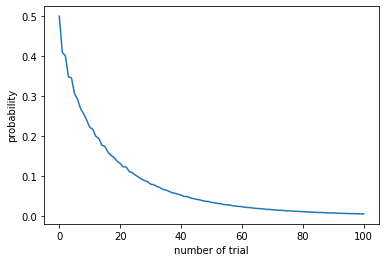

In [37]:
# コイン投げ回数0回から100回それぞれの場合の、ベイズ誤り確率を計算

zero_to_100 = np.arange(0, 101)

bayes_errors = []
for num_of_trial in tqdm(zero_to_100):
    bayes_errors.append(bayes_error(num_of_trial, pi_s, front_probs))

plt.plot(bayes_errors, label="rate of bayes error")
plt.xlabel("number of trial")
plt.ylabel("probability")
plt.show()

p.48のグラフとほぼ同じ結果になった